In [1]:
# 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys


clickmodule_dir = "/home/jovyan/eb/Documents/inbox science/clicks_nbdev/"
sys.path.append(clickmodule_dir)

#os.chdir(clickmodule_dir)

from clicks_nbdev.offline_augmentation import asnLookup

import clicks_nbdev.el_augmentation as ela

In [4]:
# Create some instances we'll need
p = ela.requestdict_parser()
asndb = asnLookup()

In [5]:
asndb.get_asn_details('172.56.20.104')

(21928, '172.56.20.0/23', 'T-MOBILE-AS21928, US')

In [6]:
print(os.getcwd())

/home/jovyan/eb/Documents/inbox science/maawg/m3_sf_2020_training


In [7]:
#parquet_path = "/home/jovyan/eb/Documents/inbox science/clicks_nbdev/temp/"

parquet_path = "/home/jovyan/eb/Documents/inbox science/clicks_nbdev/temp/step2"


In [8]:
parquet_files = []
for i in os.listdir(parquet_path):
    if i.startswith("prod_") and i.endswith("parquet"):
        parquet_files.append(i)

In [9]:
def extract_farm(filename):
    return i.replace("prod_aem_", "").split("-")[0]

In [10]:
parquet_files[0:6]

['prod_aem_elabs10-web10_access_log-20200112_step2.parquet',
 'prod_aem_elabs10-web1_access_log-20200119_step2.parquet',
 'prod_aem_elabs10-web1_access_log-20200126_step2.parquet',
 'prod_aem_elabs10-web2_access_log-20200105_step2.parquet',
 'prod_aem_elabs10-web2_access_log-20200112_step2.parquet',
 'prod_aem_elabs10-web3_access_log-20200126_step2.parquet']

In [31]:
files_to_load = 25

df_loaded = None
#pd.read_parquet(parquet_path + "/" + parquet_files[0])
for n, i in enumerate(parquet_files[0:files_to_load]):
    
    this_farm = extract_farm(i)
    
    _df = pd.read_parquet(parquet_path + "/" + i)
    _df = _df.assign(farm=this_farm)
    print(n, "shape:", _df.shape, i)
    if isinstance(df_loaded, pd.core.frame.DataFrame):
        df_loaded = pd.concat([df_loaded, _df])
    else:
        df_loaded = _df

del _df


# Some cleanup... 
#df_loaded = df.drop('ip_slash24', axis='columns')

df_loaded.drop('request_header_host', axis='columns', inplace=True)

# concat farm + mid for uniqueness
df_loaded['farm_mid'] = df_loaded['farm'] + "_" + df_loaded['mid'].astype(str)

# drop any images that managed to sneak by
_flt = df_loaded.query('el_request_type == "image"')
df_loaded.drop(_flt.index, inplace=True)

df_loaded.rename({"time_received_utc_datetimeobj":"request_time"}, axis='columns', inplace=True)

print("final shape:", df_loaded.shape)

0 shape: (56820, 26) prod_aem_elabs10-web10_access_log-20200112_step2.parquet
1 shape: (67296, 26) prod_aem_elabs10-web1_access_log-20200119_step2.parquet
2 shape: (90432, 26) prod_aem_elabs10-web1_access_log-20200126_step2.parquet
3 shape: (45297, 26) prod_aem_elabs10-web2_access_log-20200105_step2.parquet
4 shape: (58045, 26) prod_aem_elabs10-web2_access_log-20200112_step2.parquet
5 shape: (90815, 26) prod_aem_elabs10-web3_access_log-20200126_step2.parquet
6 shape: (45255, 26) prod_aem_elabs10-web4_access_log-20200105_step2.parquet
7 shape: (45556, 26) prod_aem_elabs10-web5_access_log-20200105_step2.parquet
8 shape: (67192, 26) prod_aem_elabs10-web6_access_log-20200119_step2.parquet
9 shape: (57409, 26) prod_aem_elabs10-web8_access_log-20200112_step2.parquet
10 shape: (57448, 26) prod_aem_elabs10-web9_access_log-20200112_step2.parquet
11 shape: (67867, 26) prod_aem_elabs10-web9_access_log-20200119_step2.parquet
12 shape: (28217, 26) prod_aem_elabs12-web1_access_log-20200105_step2.par

In [42]:
df = df_loaded.copy()

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610080 entries, 16 to 348058
Data columns (total 26 columns):
request_time                                          1610080 non-null datetime64[ns, UTC]
remote_ip                                             1610080 non-null object
conn_status                                           1610080 non-null object
request_method                                        1610080 non-null object
request_url_path                                      1610080 non-null object
request_url_query_simple_dict                         1610080 non-null object
status                                                1610080 non-null object
response_bytes_clf                                    1610080 non-null object
request_header_referer                                1610080 non-null object
request_header_user_agent                             1610080 non-null object
request_header_user_agent__browser__family            1610080 non-null object
request_header_u

In [30]:
df.head()

,request_time,remote_ip,conn_status,request_method,request_url_path,request_url_query_simple_dict,status,response_bytes_clf,request_header_referer,request_header_user_agent,...,el_request_type,sid,mid,mlid,ruid,asn,netblock,as_org,farm,farm_mid
index,,,,,,,,,,,,,,,,,,,,,
16,2020-01-05 03:42:16+00:00,209.73.183.25,+,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010000698', 'mid': '...",200,42,-,YahooMailProxy; https://help.yahoo.com/kb/yaho...,...,open,2010000698,5985220,365247,8f540717cf,26101,209.73.180.0/22,"YAHOO-3, US",elabs10,elabs105985220
20,2020-01-05 03:42:17+00:00,66.249.84.56,+,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010003189', 'mid': '...",200,42,-,Mozilla/5.0 (Windows NT 5.1; rv:11.0) Gecko Fi...,...,open,2010003189,5935138,323385,aafd4b9735,15169,66.249.84.0/23,"GOOGLE, US",elabs10,elabs105935138
31,2020-01-05 03:42:36+00:00,172.56.20.104,+,GET,/c.html,"{'ufl': '1', 'rtr': 'on', 's': 'x8pbpz,344ep,8...",302,26,-,Mozilla/5.0 (Linux; Android 8.1.0; LM-Q710(FGN...,...,click_html,2010002327,5231185,407154,1ccb663e58,21928,172.56.20.0/23,"T-MOBILE-AS21928, US",elabs10,elabs105231185
34,2020-01-05 03:42:41+00:00,172.219.32.58,+,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010000698', 'mid': '...",200,42,-,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,...,open,2010000698,5967275,459998,90771b26e1,852,172.219.0.0/16,"ASN852, CA",elabs10,elabs105967275
40,2020-01-05 03:42:54+00:00,66.249.81.28,+,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010002327', 'mid': '...",200,42,-,Mozilla/5.0 (Windows NT 5.1; rv:11.0) Gecko Fi...,...,open,2010002327,5286515,215864,3a08801d81,15169,66.249.80.0/22,"GOOGLE, US",elabs10,elabs105286515


In [268]:
#dtest = df.head(1000).copy()

In [20]:
for i in ['sid', 'mid', 'mlid', 'ruid']:
    if i not in df.columns:
        # Parse out EL details
        p.estimate(df.shape[0])
        %time df[dcols] = p.parse_df(df[['el_request_type', 'request_url_query_simple_dict']])

In [22]:
# Get ASN / netblock info from the IP
asn_cols = ['asn', 'netblock', 'as_org']
for i in asn_cols:
    if i not in df.columns:
        df[asn_cols] = pd.DataFrame(df['remote_ip'].apply(asndb.get_asn_details).tolist(), index=df.index)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1537572 entries, 16 to 269777
Data columns (total 24 columns):
request_time                                          1537572 non-null datetime64[ns, UTC]
remote_ip                                             1537572 non-null object
conn_status                                           1537572 non-null object
request_header_host                                   1537572 non-null object
request_method                                        1537572 non-null object
request_url_path                                      1537572 non-null object
request_url_query_simple_dict                         1537572 non-null object
status                                                1537572 non-null object
response_bytes_clf                                    1537572 non-null object
request_header_referer                                1537572 non-null object
request_header_user_agent                             1537572 non-null object
request_header_u

In [311]:
asndb = asnLookup()
asndb.get_asn_details('172.56.20.104')

(21928, '172.56.20.0/23', 'T-MOBILE-AS21928, US')

In [43]:
df.request_header_user_agent.value_counts().head(5)

Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko)                                           29041
Mozilla/5.0 (Windows NT 5.1; rv:11.0) Gecko Firefox/11.0 (via ggpht.com GoogleImageProxy)                        21183
Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/15E148    17542
YahooMailProxy; https://help.yahoo.com/kb/yahoo-mail-proxy-SLN28749.html                                          6855
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15) AppleWebKit/605.1.15 (KHTML, like Gecko)                            3602
Name: request_header_user_agent, dtype: int64

In [42]:
df.request_header_user_agent__browser__family.value_counts().head(7)

Other                         40944
Mobile Safari UI/WKWebView    24779
GmailImageProxy               21183
Apple Mail                    10281
Chrome                         9005
Outlook                        8131
IE                             7011
Name: request_header_user_agent__browser__family, dtype: int64

In [21]:
df.el_request_type.value_counts()

open               152611
click_html          21677
unknown             10222
click_text           5056
unsubscribe          1192
unsub_conf_page       761
image                   6
Name: el_request_type, dtype: int64

In [29]:
top_ips = df.remote_ip.value_counts().head(500)
# value_counts to df:
top_ips = top_ips.rename_axis('remote_ip').reset_index(name='count')

In [53]:
def df_counts(df, column, head=None):
    # returns a df of value_counts of the column.
    col = str(column)
    if head:
        top_values = df[column].value_counts().head(head)
    else:
        top_values = df[column].value_counts()
        
    colname = col + "_count"
    top_values = top_values.rename_axis(column).reset_index(name=colname)
    top_values[colname] = top_values[colname].astype('int32')
    return top_values

In [328]:
%time df[['asn', 'netblock', 'as_org']] = pd.DataFrame(df['remote_ip'].apply(asndb.get_asn_details).tolist(), index=df.index)
df['asn'] = df['asn'].astype('int32')

CPU times: user 943 ms, sys: 0 ns, total: 943 ms
Wall time: 942 ms


In [329]:
df.as_org.value_counts().head(15)

GOOGLE, US                         32875
MAILRU-AS Mail.Ru, RU              29371
COMCAST-7922, US                   11407
AMAZON-02, US                       8663
MICROSOFT-CORP-MSN-AS-BLOCK, US     3867
ATT-INTERNET4, US                   3614
BACOM, CA                           3150
CELLCO, US                          3049
ATT-MOBILITY-LLC-AS20057, US        2695
BELGACOM-SKYNET-AS, BE              2562
ASN852, CA                          2542
INKTOMI-LAWSON, US                  2484
ROGERS-COMMUNICATIONS, CA           2239
UUNET, US                           2033
SHAW, CA                            1989
Name: as_org, dtype: int64

In [22]:
df.head()

,time_received_utc_datetimeobj,remote_ip,conn_status,request_header_host,request_method,request_url_path,request_url_query_simple_dict,status,response_bytes_clf,request_header_referer,...,request_header_user_agent__browser__family,request_header_user_agent__browser__version_string,request_header_user_agent__os__family,request_header_user_agent__os__version_string,request_header_user_agent__is_mobile,ip_slash24,el_request_type,asn,netblock,as_org
index,,,,,,,,,,,,,,,,,,,,,
16,2020-01-05 03:42:16+00:00,209.73.183.25,+,www.elabs10.com,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010000698', 'mid': '...",200,42,-,...,Other,,Other,,False,209.73.183.0,open,26101,209.73.180.0/22,"YAHOO-3, US"
20,2020-01-05 03:42:17+00:00,66.249.84.56,+,click.crewardsmailing.com,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010003189', 'mid': '...",200,42,-,...,GmailImageProxy,,Windows,XP,False,66.249.84.0,open,15169,66.249.84.0/23,"GOOGLE, US"
31,2020-01-05 03:42:36+00:00,172.56.20.104,+,www.elabs10.com,GET,/c.html,"{'ufl': '1', 'rtr': 'on', 's': 'x8pbpz,344ep,8...",302,26,-,...,Chrome Mobile,79.0.3945,Android,8.1.0,True,172.56.20.0,click_html,21928,172.56.20.0/23,"T-MOBILE-AS21928, US"
34,2020-01-05 03:42:41+00:00,172.219.32.58,+,www.elabs10.com,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010000698', 'mid': '...",200,42,-,...,Apple Mail,605.1.15,Mac OS X,10.14.6,False,172.219.32.0,open,852,172.219.0.0/16,"ASN852, CA"
40,2020-01-05 03:42:54+00:00,66.249.81.28,+,click.rewardsdealmail.com,GET,/images/mlopen_post.html,"{'rtr': 'on', 'siteid': '2010002327', 'mid': '...",200,42,-,...,GmailImageProxy,,Windows,XP,False,66.249.81.0,open,15169,66.249.80.0/22,"GOOGLE, US"


In [23]:
df.netblock.value_counts().head()

188.93.56.0/21     62721
209.222.82.0/24    49788
74.125.0.0/16      45611
64.233.172.0/23    40571
66.102.8.0/23      33378
Name: netblock, dtype: int64

In [24]:
n_by_netblock = pd.DataFrame(df.groupby(["netblock", "as_org", "asn"])["netblock"].count())

In [25]:
n_by_netblock = n_by_netblock.rename(columns={"netblock":"netblock_count"})

# Groupby convers the grouped columns to the index, so we reset them to regular columns.
n_by_netblock = n_by_netblock.sort_values('netblock_count', axis='index', ascending=False).reset_index()

In [163]:
def value_counts_multi(df, group_column, return_columns):
    # Returns a new df, grouped by specified columns, returning return_columns, sorted by count descending.
    # return_columns should be a list.
    
    newcolname = str(group_column) + "_count"
    
    df1 = pd.DataFrame(df.groupby(return_columns)[group_column].count())
    df1 = df1.rename(columns={group_column:newcolname}).reset_index().sort_values(newcolname, ascending=False)
    return df1.reset_index().drop('index', axis='columns')
    
    
    

In [164]:
# Let's just get the top 10 IPs that are clicking.
#cdf['remote_ip'].value_counts().head(10)

value_counts_multi(cdf, 'remote_ip', ['remote_ip', 'asn', 'as_org']).head(10)

,remote_ip,asn,as_org,remote_ip_count
0,65.154.226.220,54538,"PAN0001, US",5437
1,169.61.122.229,36351,"SOFTLAYER, US",5139
2,65.154.226.100,54538,"PAN0001, US",3899
3,65.155.30.101,6461,"ZAYO-6461, US",2856
4,65.154.226.109,54538,"PAN0001, US",1776
5,209.222.82.140,16509,"AMAZON-02, US",1547
6,209.222.82.164,16509,"AMAZON-02, US",1511
7,209.222.82.131,16509,"AMAZON-02, US",1496
8,209.222.82.134,16509,"AMAZON-02, US",1489
9,209.222.82.137,16509,"AMAZON-02, US",1488


In [44]:
cdf = df.query('(el_request_type == "click_html" or el_request_type == "click_text") and mid > 0').copy()

print(cdf.shape)

test = 0

if test:
    cdf = cdf.head(5000).copy()

(210621, 26)


In [45]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210621 entries, 31 to 347948
Data columns (total 26 columns):
request_time                                          210621 non-null datetime64[ns, UTC]
remote_ip                                             210621 non-null object
conn_status                                           210621 non-null object
request_method                                        210621 non-null object
request_url_path                                      210621 non-null object
request_url_query_simple_dict                         210621 non-null object
status                                                210621 non-null object
response_bytes_clf                                    210621 non-null object
request_header_referer                                210621 non-null object
request_header_user_agent                             210621 non-null object
request_header_user_agent__browser__family            210621 non-null object
request_header_user_agent__b

In [40]:
# We can write a function to let us do this more easily for other fields.
def is_in_top_x(series, x):
    # Returns a series: True if the item is in the most common x values, otherwise False.
    topx_values = series.value_counts().head(x).index.tolist()
    return series.isin(topx_values)

In [41]:
# Set a column in the original DF using this function.
cdf['in_top10_ips'] = is_in_top_x(cdf['remote_ip'], 10)

In [42]:
# We can see how many are/are not within the top 10:
cdf['in_top10_ips'].value_counts()

False    174889
True      25346
Name: in_top10_ips, dtype: int64

In [43]:
# Let's look at the top 10 user-agents too.
cdf['request_header_user_agent'].value_counts().head(10)

Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0)                                                                                                                                   34929
Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; .NET CLR 3.5.30729; .NET CLR 3.0.30729)                                                         21214
Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.4 Mobile/15E148 Safari/604.1                                                         16951
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/57.0.2987.133 Safari/537.36                                                                                5679
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36                                                                                 5573


In [369]:
cdf['in_top10_UAs'] = is_in_top_x(cdf['request_header_user_agent'], 10)

In [370]:
cdf['in_top10_UAs'].value_counts()

False    870
True     630
Name: in_top10_UAs, dtype: int64

In [77]:
min_timestamp_per_message = cdf.groupby('farm_mid')['request_time'].min()
mints = pd.DataFrame(min_timestamp_per_message)
mints = mints.rename({"request_time":"min_request_time"}, axis='columns')
mints.head()

,min_request_time
farm_mid,
elabs10_10046383,2020-01-23 16:04:52+00:00
elabs10_1005134,2020-01-11 01:32:30+00:00
elabs10_10089307,2020-01-15 14:42:16+00:00
elabs10_10415321,2020-01-12 15:22:36+00:00
elabs10_10605819,2020-01-24 20:15:11+00:00


,min_request_time
farm_mid,
elabs10_10046383,2020-01-23 16:04:52+00:00
elabs10_1005134,2020-01-11 01:32:30+00:00
elabs10_10089307,2020-01-15 14:42:16+00:00
elabs10_10415321,2020-01-12 15:22:36+00:00
elabs10_10605819,2020-01-24 20:15:11+00:00


In [63]:
counts_per_message = df_counts(cdf, 'farm_mid')
counts_per_message = counts_per_message.set_index('farm_mid')
counts_per_message.head()

,farm_mid_count
farm_mid,
elabs10_5967362,12691
elabs10_5991493,7706
elabs10_5997551,7106
elabs12_1918468,5361
elabs12_1915872,4515


In [60]:
counts_per_message.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 2 columns):
farm_mid          5826 non-null object
farm_mid_count    5826 non-null int32
dtypes: int32(1), object(1)
memory usage: 68.4+ KB


In [64]:
cdf2 = cdf.join(counts_per_message, 'farm_mid')

In [67]:
cdf3 = cdf2.query('farm_mid_count > 20')

In [78]:
cdf3 = cdf3.join(mints, 'farm_mid')

In [79]:
cdf3.head()

,request_time,remote_ip,conn_status,request_method,request_url_path,request_url_query_simple_dict,status,response_bytes_clf,request_header_referer,request_header_user_agent,...,mid,mlid,ruid,asn,netblock,as_org,farm,farm_mid,farm_mid_count,min_request_time
index,,,,,,,,,,,,,,,,,,,,,
31,2020-01-05 03:42:36+00:00,172.56.20.104,+,GET,/c.html,"{'ufl': '1', 'rtr': 'on', 's': 'x8pbpz,344ep,8...",302,26,-,Mozilla/5.0 (Linux; Android 8.1.0; LM-Q710(FGN...,...,5231185,407154,1ccb663e58,21928,172.56.20.0/23,"T-MOBILE-AS21928, US",elabs10,elabs10_5231185,342,2019-12-29 10:03:52+00:00
72,2020-01-05 03:43:59+00:00,70.171.39.169,+,GET,/c.html,"{'ufl': '7', 'rtr': 'on', 's': 'x8pbmi,3jwg2,5...",302,26,-,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like M...,...,5967362,247198,77ceec4b2b,22773,70.171.0.0/18,"ASN-CXA-ALL-CCI-22773-RDC, US",elabs10,elabs10_5967362,12691,2020-01-01 15:14:09+00:00
343,2020-01-05 03:54:04+00:00,64.233.173.186,+,GET,/c.html,"{'ufl': 'b', 'rtr': 'on', 's': 'x8pbpz,349cv,8...",302,26,android-app://com.google.android.gm,Mozilla/5.0 (Linux; Android 7.0; SM-G925I) App...,...,5237599,403043,b94128d749,15169,64.233.172.0/23,"GOOGLE, US",elabs10,elabs10_5237599,51,2019-12-29 21:37:20+00:00
518,2020-01-05 04:00:37+00:00,174.99.90.183,+,GET,/c.html,"{'ufl': '1', 'rtr': 'on', 's': 'x8pbpz,3abmj,8...",302,26,-,Mozilla/5.0 (Linux; Android 10; SM-N975U) Appl...,...,5520475,407154,1f2df0d018,11426,174.98.0.0/15,"TWC-11426-CAROLINAS, US",elabs10,elabs10_5520475,296,2019-12-29 05:35:46+00:00
590,2020-01-05 04:03:14+00:00,45.42.97.53,+,GET,/c.html,"{'ufl': '5', 'rtr': 'on', 's': 'x8pbpz,2z7tz,8...",302,26,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,...,5002343,377732,58d5cdbf0c,11814,45.42.96.0/22,"DISTRIBUTEL-AS11814, CA",elabs10,elabs10_5002343,1093,2019-12-29 03:32:53+00:00


In [80]:
cdf3['click_delay'] = cdf3.request_time - cdf3.min_request_time

In [81]:
cdf3.head()

,request_time,remote_ip,conn_status,request_method,request_url_path,request_url_query_simple_dict,status,response_bytes_clf,request_header_referer,request_header_user_agent,...,mlid,ruid,asn,netblock,as_org,farm,farm_mid,farm_mid_count,min_request_time,click_delay
index,,,,,,,,,,,,,,,,,,,,,
31,2020-01-05 03:42:36+00:00,172.56.20.104,+,GET,/c.html,"{'ufl': '1', 'rtr': 'on', 's': 'x8pbpz,344ep,8...",302,26,-,Mozilla/5.0 (Linux; Android 8.1.0; LM-Q710(FGN...,...,407154,1ccb663e58,21928,172.56.20.0/23,"T-MOBILE-AS21928, US",elabs10,elabs10_5231185,342,2019-12-29 10:03:52+00:00,6 days 17:38:44
72,2020-01-05 03:43:59+00:00,70.171.39.169,+,GET,/c.html,"{'ufl': '7', 'rtr': 'on', 's': 'x8pbmi,3jwg2,5...",302,26,-,Mozilla/5.0 (iPhone; CPU iPhone OS 13_3 like M...,...,247198,77ceec4b2b,22773,70.171.0.0/18,"ASN-CXA-ALL-CCI-22773-RDC, US",elabs10,elabs10_5967362,12691,2020-01-01 15:14:09+00:00,3 days 12:29:50
343,2020-01-05 03:54:04+00:00,64.233.173.186,+,GET,/c.html,"{'ufl': 'b', 'rtr': 'on', 's': 'x8pbpz,349cv,8...",302,26,android-app://com.google.android.gm,Mozilla/5.0 (Linux; Android 7.0; SM-G925I) App...,...,403043,b94128d749,15169,64.233.172.0/23,"GOOGLE, US",elabs10,elabs10_5237599,51,2019-12-29 21:37:20+00:00,6 days 06:16:44
518,2020-01-05 04:00:37+00:00,174.99.90.183,+,GET,/c.html,"{'ufl': '1', 'rtr': 'on', 's': 'x8pbpz,3abmj,8...",302,26,-,Mozilla/5.0 (Linux; Android 10; SM-N975U) Appl...,...,407154,1f2df0d018,11426,174.98.0.0/15,"TWC-11426-CAROLINAS, US",elabs10,elabs10_5520475,296,2019-12-29 05:35:46+00:00,6 days 22:24:51
590,2020-01-05 04:03:14+00:00,45.42.97.53,+,GET,/c.html,"{'ufl': '5', 'rtr': 'on', 's': 'x8pbpz,2z7tz,8...",302,26,-,Mozilla/5.0 (Windows NT 6.3; Win64; x64) Apple...,...,377732,58d5cdbf0c,11814,45.42.96.0/22,"DISTRIBUTEL-AS11814, CA",elabs10,elabs10_5002343,1093,2019-12-29 03:32:53+00:00,7 days 00:30:21


In [171]:
cdf3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194221 entries, 31 to 347847
Data columns (total 29 columns):
request_time                                          194221 non-null datetime64[ns, UTC]
remote_ip                                             194221 non-null object
conn_status                                           194221 non-null object
request_method                                        194221 non-null object
request_url_path                                      194221 non-null object
request_url_query_simple_dict                         194221 non-null object
status                                                194221 non-null object
response_bytes_clf                                    194221 non-null object
request_header_referer                                194221 non-null object
request_header_user_agent                             194221 non-null object
request_header_user_agent__browser__family            194221 non-null object
request_header_user_agent__b

In [ ]:
newcolname

In [174]:
### doesn't work quite right. 

ips_df = value_counts_multi(cdf3, group_column='ip_slash24', return_columns=['ip_slash24', 'asn', 'as_org']).head(15)
ips_df

,ip_slash24,asn,as_org,ip_slash24_count
0,209.222.82.0,16509,"AMAZON-02, US",20316
1,65.154.226.0,54538,"PAN0001, US",11071
2,169.61.122.0,36351,"SOFTLAYER, US",5139
3,65.155.30.0,6461,"ZAYO-6461, US",2744
4,154.47.76.0,174,"COGENT-174, US",2475
5,66.102.8.0,15169,"GOOGLE, US",2428
6,45.41.142.0,22400,"WEB2OBJECTS, US",2406
7,203.189.3.0,9517,"CATHEDBNE-AS-AP Brisbane Catholic Education, AU",1332
8,74.125.210.0,15169,"GOOGLE, US",1135
9,107.1.86.0,7922,"COMCAST-7922, US",1116


In [199]:
filtercol = 'ip_slash24'

ips_list = ips_df[filtercol].tolist()

ip_to_research = ips_list[13]

asndb.get_asn_details(ip_to_research)

(25640, '66.27.46.0/24', 'HAWAII-DEPT-OF-EDUC, US')

14626.336666666664


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feafb489210>]],
      dtype=object)

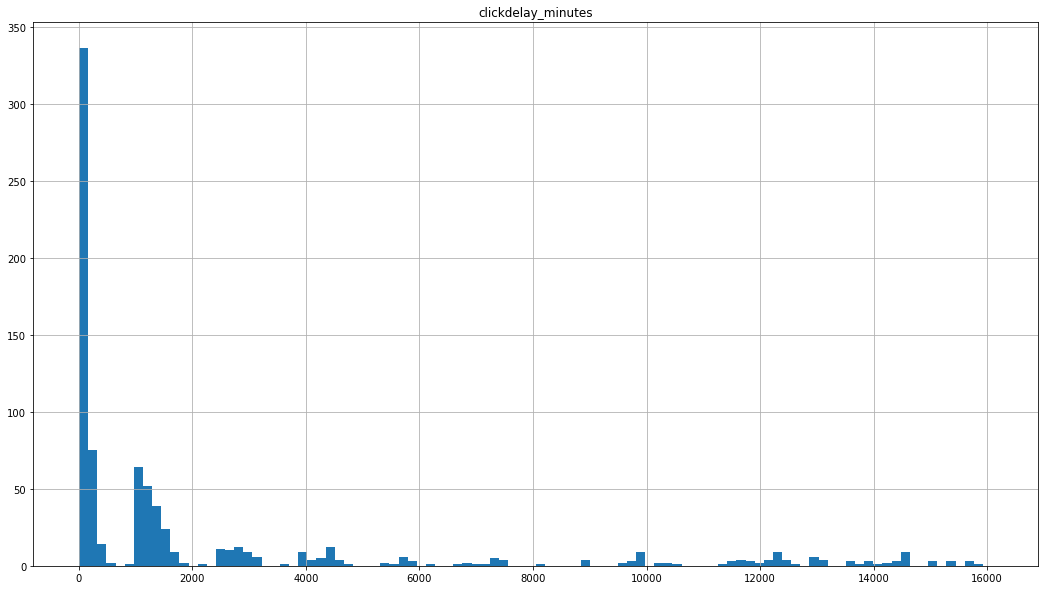

In [200]:
# Let's start looking at how the data looks for this IP.

cdftop1 = cdf3[cdf3[filtercol] == ip_to_research].copy()

# Need to convert from timedelta type to plot a hist on it.
cdftop1['clickdelay_minutes'] = cdftop1.click_delay / pd.Timedelta(minutes=1)


# Cut off values > 75th pctile
pctile = 0.95
pctile_value = cdftop1['clickdelay_minutes'].quantile(pctile)

print(pctile_value)

#upper_bound = cdftop1['clickdelay_minutes'].mean() + 1 + 2 * cdftop1['clickdelay_minutes'].std()
upper_bound = pctile_value * 1.1

# Calculate bins, evenly spaced
bin_count = 100
bins = [(i * upper_bound / bin_count) for i in range(bin_count+1)]


cdftop1.hist(column='clickdelay_minutes', bins=bins, figsize=(18,10))

In [202]:
cdftop1.request_header_user_agent.value_counts().head(15)

Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36          149
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36            81
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36     55
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36            44
Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36             38
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.88 Safari/537.36      29
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.117 Safari/537.36     24
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.